# BeatTeller: Tempo Detection using Machine Learning
BeatTeller is machine learning model which aims to improve already existing tempo detection algorithms via machine learning.
- `pip install librosa` is a wonderful python library with lots of cool audio processing tools.
- This model is trained on a dataset of electronic music tracks with known tempos.
- The model uses that data, combined with features obtained from the wave form via librosa, to predict the tempo of the track.
The model combines traditional audio processing techniques with deep learning to provide accurate tempo predictions.

## Dataset
- Custom dataset of electronic music tracks with known tempos
- Files are named with their tempo: e.g. "140 Artist - Track.mp3"
- Uses middle section of tracks to avoid intros without beat structure
- download ![here](https://drive.google.com/drive/folders/1Ga60S47Ap-Stp6Bspx79KQG6hZIkGvV_?usp=sharing)
  - warning: this dataset is quite large (~1.6GB). I plan to serialize the librosa spectral data eventually, but I wanted to priotitize running initial initial tests.
## Approach
1. Extract audio features using librosa
2. Combine ML predictions with librosa's tempo detection
3. Train model to learn optimal weighting between the two methods

First, I'll need a Dataset class so that I can consistently load and preprocess the data. By inheriting from the Dataset (pytorch) class, I can use the same methods to load the data for training and testing. (I know this is machine learning, but OOP FTW!).  

For now, I've prepared ~60 songs with known tempos.  Since I've been making and playing music for a while, I have more than enough audio files with known tempos to make my own dataset.  It will be more tedious than anything, as I'll need to manually label each track.  Since many electronic songs have atmospheric or ambient elements in their intros, I'll start 1/3 into the track to avoid confusing the model.

To label my data in a way python can easily understand, I'll process the file name of each song as a string and extract the tempo from it.
 
### RekordboxAudioDataset
- audio_dir: Directory containing audio files with tempo prefixes
- Format example: '140 Doctor P - Watch Out.mp3'

In [19]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
from tinytag import TinyTag
from torch.utils.data import random_split
import pandas as pd
import os
from datetime import datetime
from torch import optim

In [22]:
class RekordboxAudioDataset(Dataset):
    def __init__(self, audio_dir, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform
        self.audio_files = []
        self.true_tempos = []
        self.librosa_tempos = []
        self.onset_strengths = []
        self.features = []
        
        tempo_pattern = re.compile(r'^(\d+\.?\d*)\s+(.+)$')
        
        all_audio_files = [f for f in os.listdir(audio_dir) 
                          if f.endswith(('.mp3', '.wav', '.aiff', '.m4a'))]
        unsuccessful_files = []
        
        for filename in all_audio_files:
            match = tempo_pattern.match(filename)
            if match:
                try:
                    true_tempo = float(match.group(1))
                    audio_path = os.path.join(audio_dir, filename)
                    
                    tag = TinyTag.get(audio_path)
                    offset = tag.duration / 3 if tag.duration else 0
                    y, sr = librosa.load(audio_path, offset=offset, duration=30)
                    
                    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
                    librosa_tempo = float(tempo.item())
                    
                    if librosa_tempo < 78 or librosa_tempo > 155:
                        librosa_tempo = self.normalize_tempo(librosa_tempo, true_tempo)
                    
                    features = self._extract_features(y, sr)
                    if features.shape[0] != 32:  # Updated shape check
                        print(f"Skipping {filename}: Unexpected feature shape {features.shape}")
                        continue
                    
                    self.audio_files.append(filename)
                    self.true_tempos.append(true_tempo)
                    self.librosa_tempos.append(librosa_tempo)
                    self.features.append(features)
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue
            else:
                unsuccessful_files.append(filename)
        
        print(f"Successfully loaded {len(self.audio_files)} files")
        if len(unsuccessful_files) != 0:
            print(f"Failed to load {len(unsuccessful_files)} files:")
            for file in unsuccessful_files:
                print(f"  - {file}")
        
        if len(self.audio_files) == 0:
            raise Exception("No valid audio files found with tempo labels")
    
    def normalize_tempo(self, librosa_tempo, true_tempo):
        while librosa_tempo < 78:
            librosa_tempo *= 2
        while librosa_tempo > 155:
            librosa_tempo /= 2
            
        if librosa_tempo * 2 <= 155:
            if abs(librosa_tempo * 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo *= 2
        if librosa_tempo / 2 >= 78:
            if abs(librosa_tempo / 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo /= 2
                
        return librosa_tempo

    def normalize_targets(self, true_tempo, librosa_tempo):
        return (true_tempo - 78) / 77, (librosa_tempo - 78) / 77

    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        try:
            true_tempo = self.true_tempos[idx]
            librosa_tempo = self.librosa_tempos[idx]
            features = self.features[idx]
            
            if self.transform:
                features = self.transform(features)
            
            features = torch.FloatTensor(features)
            true_tempo_norm, librosa_tempo_norm = self.normalize_targets(true_tempo, librosa_tempo)
            targets = torch.tensor([[true_tempo_norm, librosa_tempo_norm]], dtype=torch.float32)
            
            return features, targets
            
        except Exception as e:
            print(f"Error loading item {idx} ({self.audio_files[idx]}): {str(e)}")
            return torch.zeros((32, 1292), dtype=torch.float32), torch.zeros((1, 2), dtype=torch.float32)

    def _extract_features(self, y, sr):
        try:
            # Fixed parameters
            hop_length = 512
            n_fft = 1024
            
            # Ensure audio length is consistent
            target_length = 30 * sr
            if len(y) > target_length:
                y = y[:target_length]
            elif len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)))
            
            # Core rhythm features
            onset_env = librosa.onset.onset_strength(
                y=y, 
                sr=sr,
                hop_length=hop_length
            )
            onset_env = librosa.util.normalize(onset_env)
            
            # Beat tracking with two different configurations
            tempo1, beats1 = librosa.beat.beat_track(
                y=y, sr=sr, 
                hop_length=hop_length, 
                start_bpm=120, 
                tightness=100
            )
            
            tempo2, beats2 = librosa.beat.beat_track(
                y=y, sr=sr, 
                hop_length=hop_length, 
                start_bpm=140, 
                tightness=50
            )
            
            # Convert beats to onset envelopes
            beat_env1 = np.zeros(len(onset_env))
            beat_env2 = np.zeros(len(onset_env))
            beat_frames1 = beats1[beats1 < len(beat_env1)]
            beat_frames2 = beats2[beats2 < len(beat_env2)]
            beat_env1[beat_frames1] = 1.0
            beat_env2[beat_frames2] = 1.0
            
            # Compute reduced tempogram (fewer bands)
            tempogram = librosa.feature.tempogram(
                onset_envelope=onset_env,
                sr=sr,
                hop_length=hop_length,
                win_length=384
            )
            
            # Reduce to fewer bands
            n_bands = 29  # Much smaller than before
            tempogram_reduced = np.zeros((n_bands, tempogram.shape[1]))
            band_size = tempogram.shape[0] // n_bands
            for i in range(n_bands):
                start_idx = i * band_size
                end_idx = (i + 1) * band_size
                tempogram_reduced[i] = np.mean(tempogram[start_idx:end_idx], axis=0)
            
            # Stack features - now only 32 total features
            features = np.vstack([
                onset_env.reshape(1, -1),      # 1 band
                beat_env1.reshape(1, -1),      # 1 band
                beat_env2.reshape(1, -1),      # 1 band
                tempogram_reduced              # 29 bands
            ])
            
            # Verify new shape (32 features)
            assert features.shape[0] == 32, f"Expected 32 frequency bins, got {features.shape[0]}"
            
            # Normalize
            features = (features - features.mean()) / (features.std() + 1e-8)
            
            return features
                
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return np.zeros((32, 1292))  # Adjusted shape
        

Now that I have a framework for processing audio files, I can initialize the dataset:
- tempos are normalized to be within 78-155 BPM
- onset strength is normalized to be between 0 and 1

In [23]:
audio_dir = "TellerNet/data/beatbank_test_audios"
dataset = RekordboxAudioDataset(audio_dir)

Successfully loaded 196 files


With the dataset initialized, I'd first like to run some tests to see how well librosa is at predicting tempos on its own.  I'll get all of the `true_tempos` and `librosa_tempos` from the dataset and then compare them both with text and visually.


Librosa Accuracy:
Within 5 BPM: 85.2%
Within 10 BPM: 85.7%
Average BPM difference: 6.6


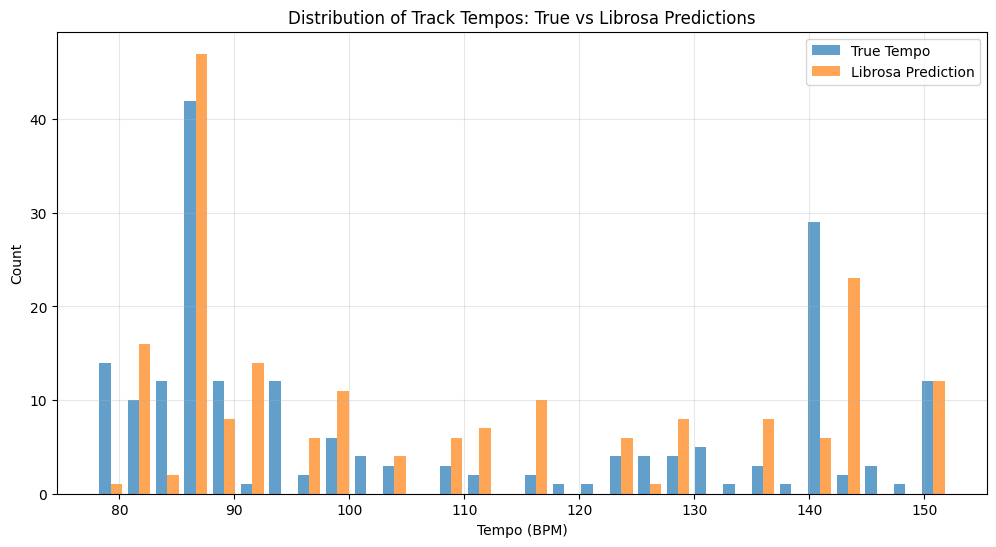

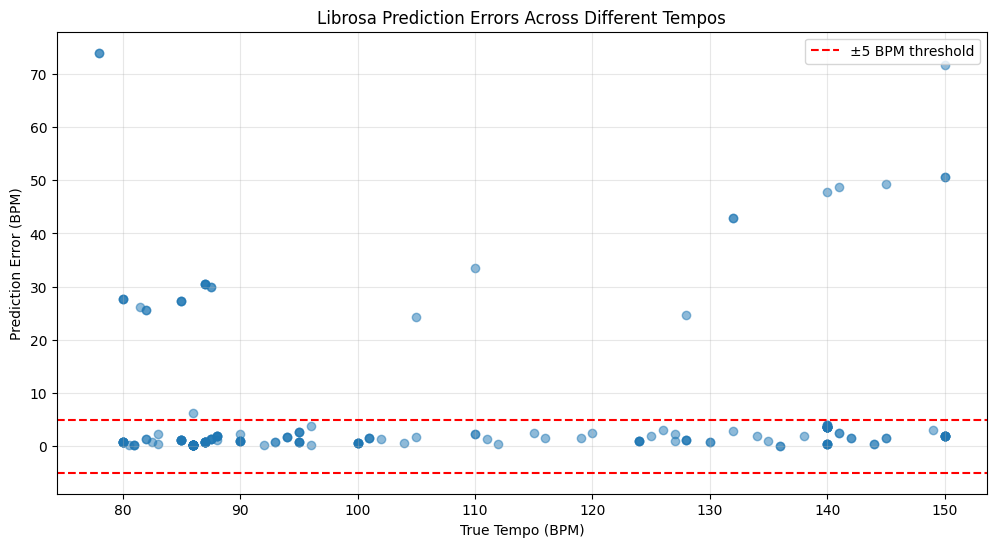

In [ ]:
# Calculate librosa's accuracy
true_tempos = np.array(dataset.true_tempos).flatten()
librosa_tempos = np.array(dataset.librosa_tempos).flatten()
tempo_differences = np.abs(true_tempos - librosa_tempos)

within_5_bpm = np.mean(tempo_differences < 5) * 100
within_10_bpm = np.mean(tempo_differences < 10) * 100

print(f"\nLibrosa Accuracy:")
print(f"Within 5 BPM: {within_5_bpm:.1f}%")
print(f"Within 10 BPM: {within_10_bpm:.1f}%")
print(f"Average BPM difference: {np.mean(tempo_differences):.1f}")

# Visualize tempo distributions
plt.figure(figsize=(12, 6))
plt.hist([true_tempos, librosa_tempos], 
         label=['True Tempo', 'Librosa Prediction'],
         alpha=0.7,
         bins=30)
plt.xlabel('Tempo (BPM)')
plt.ylabel('Count')
plt.title('Distribution of Track Tempos: True vs Librosa Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize prediction errors
plt.figure(figsize=(12, 6))
plt.scatter(true_tempos, tempo_differences, alpha=0.5)  # Using flattened arrays
plt.xlabel('True Tempo (BPM)')
plt.ylabel('Prediction Error (BPM)')
plt.title('Librosa Prediction Errors Across Different Tempos')
plt.axhline(y=5, color='r', linestyle='--', label='±5 BPM threshold')
plt.axhline(y=-5, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

results (204 beats):
```
Librosa Accuracy:
Within 5 BPM: 59.1%
Within 10 BPM: 59.1%
Average BPM difference: 28.1
```
![true vs librosa tempo](output_librosa_204-1.png)
![error across tempos](output_librosa_204-1.png)


results after normalizing tempo to 78-155 BPM:
```
Librosa Accuracy:
Within 5 BPM: 85.2%
Within 10 BPM: 85.7%
Average BPM difference: 6.6
```
![true vs librosa tempo](output_librosa_204-1.png)
![error across tempos](output_librosa_204-1.png)


![true vs librosa tempo](out_lib_3-2.png)
![error across tempos](out_lib_3-2.png)


As seen here, librosa is *just okay* at analyzing tempos.  With machine learning, we can make it better. An average BPM error of 24.24.5BPM isn't particularly useful.  With DJ's needing precise tempo estimations, improvements in accuracy are needed if before this will ever get used in a real-world setting.

Looking at the graphs, when librosa is wrong, it's *very* wrong.  On the other hand, librosa's accurate predictions are very close to the mark.  With this in mind, I decided to normalize the librosa tempos to be within 78-155 BPM.  I did this inside of the loop, so that each song's tempo gets normalized to be within the same range.  This gets rid of a lot of the "tempo vagueness" outliers (e.g. a song being labeled as 80BPM instead of 160BPM).

As a result, massive increases were observed in the accuracy of librosa's tempo predictions (average error went from 28BPM to 6!).  This will provide a better foundation for training the model.

It's time to see if we can use machine learning to improve librosa's accuracy. I'll make another class for the model, and then I'll train it on the dataset.

In [24]:
class TellerNet(nn.Module):
    def __init__(self):
        super(TellerNet, self).__init__()
        
        self.freq_convs = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 32, kernel_size=(3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        
        self.lstm = nn.LSTM(
            input_size=64 * 32,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        self.attention = nn.MultiheadAttention(128, 4)
        self.post_attention_dropout = nn.Dropout(0.3)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32, 2)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1)
        x = self.freq_convs(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(batch_size, x.size(1), -1)
        x, _ = self.lstm(x)
        x, _ = self.attention(x, x, x)
        x = self.post_attention_dropout(x)
        x = torch.mean(x, dim=1)
        x = self.fc_layers(x)
        return x

Now, time for the training parameters:
- 80/20 split
- logging via csv as well as png for visualization / analysis
- batch sizes (might change later)
    - 32 for training
    - 16 for validation


### Parameters

In [30]:
# vars
import torch.nn.functional as F
decay_val = 1e-5
factor_val = 0.8
warmup_epochs = 0
base_lr = 0.0001
max_lr = 0.001

patience_val = 10
num_epochs = 125
# Create directories for logs if they don't exist
log_dir = os.path.join('logs')
os.makedirs(log_dir, exist_ok=True)

# Define split sizes (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

model = TellerNet()

# Setup training components
device = torch.device("cuda")
model = model.to(device)
class TempoLoss(nn.Module):
    def forward(self, pred, target):
        mse_loss = F.mse_loss(pred, target)
        tempo_pred = pred[:, 0]
        tempo_target = target[:, 0]
        tempo_error = torch.abs(tempo_pred - tempo_target)
        tempo_loss = torch.mean(tempo_error ** 2)
        return mse_loss + 0.05 * tempo_loss

criterion = TempoLoss()


# optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    div_factor=10,
    final_div_factor=100
)

# Lists to store metrics
train_losses = []
val_losses = []
epoch_errors = []
best_val_loss = float('inf')

# Training parameters

# Create timestamp for this training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
columns = ['Epoch', 'Training_Loss', 'Validation_Loss', 'Avg_BPM_Error',
           'Max_BPM_Error', 'Learning_Rate']
training_log = pd.DataFrame(columns=columns)


#### helper functions for training loop

In [26]:

def get_warmup_lr(epoch, warmup_epochs, initial_lr, target_lr):
    if epoch >= warmup_epochs:
        return target_lr
    return initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
def denormalize_targets(self, true_tempo_norm, librosa_tempo_norm):
    return (true_tempo_norm * 77) + 78, (librosa_tempo_norm * 77) + 78

With all the data loaded, I can now see how my model does on the test set.
- Kaimer initialization for weights to improve starting accuracy
- I need to restart my computer.... lol
- serializing the data might improve performance, my computer is strugglingz

### Training Loop

beginning epoch:  0


C:\Users\parke\AppData\Local\Temp\ipykernel_11916\3982124240.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  training_log = pd.concat([training_log, log_row], ignore_index=True)


Epoch 1/125
Training Loss: 0.2355
Validation Loss: 0.1474
Average BPM Error: 25.7
Max BPM Error: 53.9
Learning Rate: 0.00010000000000000005
--------------------------------------------------
New best model saved! Validation Loss: 0.1474

beginning epoch:  1
Epoch 2/125
Training Loss: 0.1722
Validation Loss: 0.1241
Average BPM Error: 26.6
Max BPM Error: 35.7
Learning Rate: 0.00010001587583240059
--------------------------------------------------
New best model saved! Validation Loss: 0.1241

beginning epoch:  2
Epoch 3/125
Training Loss: 0.1623
Validation Loss: 0.1244
Average BPM Error: 26.3
Max BPM Error: 38.7
Learning Rate: 0.00010006350220941507
--------------------------------------------------
beginning epoch:  3
Epoch 4/125
Training Loss: 0.1523
Validation Loss: 0.1307
Average BPM Error: 26.0
Max BPM Error: 45.3
Learning Rate: 0.00010014287577056209
--------------------------------------------------
beginning epoch:  4
Epoch 5/125
Training Loss: 0.1540
Validation Loss: 0.1333
Aver

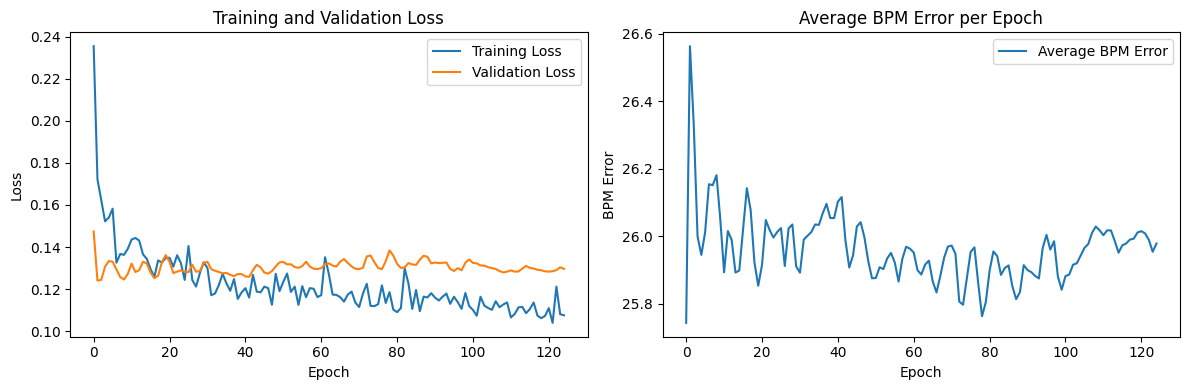


Training Complete!
Best Validation Loss: 0.1241
Final Average BPM Error: 26.0
Average Training Loss: 0.1222
Average Validation Loss: 0.1305
Training plot saved to: logs\training_plot_20241125_213807.png

Final Training Log:


,Epoch,Training_Loss,Validation_Loss,Avg_BPM_Error,Max_BPM_Error,Learning_Rate
0,1,0.235487,0.147440,25.742817,53.917961,0.000100
1,2,0.172164,0.124062,26.563171,35.713242,0.000100
2,3,0.162325,0.124414,26.329920,38.652374,0.000100
3,4,0.152253,0.130683,25.998981,45.270638,0.000100
4,5,0.154024,0.133345,25.944321,46.363380,0.000100
...,...,...,...,...,...,...
120,121,0.110967,0.128320,26.014820,44.953506,0.000310
121,122,0.103966,0.128515,26.008045,45.089020,0.000313
122,123,0.121189,0.129055,25.988815,45.473587,0.000316
123,124,0.108084,0.130379,25.953594,46.178024,0.000320


In [ ]:
import gc

max_norm = 2.0  # Gradient clipping threshold
torch.cuda.empty_cache()
gc.collect()  # garbage collect
# Training loop
for epoch in range(num_epochs):
    if epoch % 5 == 0:  # Every 5 epochs
        torch.cuda.empty_cache() # garbage collect
        gc.collect()
    # Training phase
    print("beginning epoch: ", epoch)
    model.train() 
    train_loss = 0.0
    train_bpm_errors = []
    
    for features, targets in train_loader:
        
        features = features.to(device)
        targets = targets.squeeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        
        # get loss from normalized values
        loss = criterion(outputs, targets)
        
        # Denormalize for BPM error calculation
        outputs_denorm = outputs.detach().cpu().numpy()
        targets_denorm = targets.detach().cpu().numpy()
        true_tempos = (targets_denorm[:, 0] * 77) + 78
        pred_tempos = (outputs_denorm[:, 0] * 77) + 78
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        
        train_loss += loss.item()
        bpm_errors = np.abs(true_tempos - pred_tempos)
        train_bpm_errors.extend(bpm_errors)

    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_bpm_errors = []
    
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.squeeze(1).to(device)
            outputs = model(features)
            
            # get loss from normalized values
            loss = criterion(outputs, targets)
            
            # Denormalize for BPM error calculation
            outputs_denorm = outputs.detach().cpu().numpy()
            targets_denorm = targets.detach().cpu().numpy()
            true_tempos = (targets_denorm[:, 0] * 77) + 78
            pred_tempos = (outputs_denorm[:, 0] * 77) + 78
            
            val_loss += loss.item()
            bpm_errors = np.abs(true_tempos - pred_tempos)
            val_bpm_errors.extend(bpm_errors)
    
    # Calculate metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_bpm_error = np.mean(val_bpm_errors)
    max_bpm_error = np.max(val_bpm_errors)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    epoch_errors.append(avg_bpm_error)
    
    # Add row to training log DataFrame using concat
    log_row = pd.DataFrame([{
    'Epoch': int(epoch + 1),
    'Training_Loss': float(avg_train_loss),
    'Validation_Loss': float(avg_val_loss),
    'Avg_BPM_Error': float(avg_bpm_error),
    'Max_BPM_Error': float(max_bpm_error),
    'Learning_Rate': float(current_lr)
    }])
    training_log = pd.concat([training_log, log_row], ignore_index=True)
    
    # Update learning rate
    scheduler.step()
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Average BPM Error: {avg_bpm_error:.1f}')
    print(f'Max BPM Error: {max_bpm_error:.1f}')
    print(f'Learning Rate: {current_lr}')
    print('-' * 50)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'bpm_error': avg_bpm_error
        }, f'models/teller_net_{timestamp}_best.pth')
        print(f'New best model saved! Validation Loss: {avg_val_loss:.4f}\n')

# Save training log to CSV
csv_path = os.path.join(log_dir, f'training_log_{timestamp}.csv')
training_log.to_csv(csv_path, index=False)
print(f"Training log saved to: {csv_path}")

# Plot and save final results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epoch_errors, label='Average BPM Error')
plt.xlabel('Epoch')
plt.ylabel('BPM Error')
plt.legend()
plt.title('Average BPM Error per Epoch')

plt.tight_layout()

# Save plot
plot_path = os.path.join(log_dir, f'training_plot_{timestamp}.png')
plt.savefig(plot_path)
plt.show()

print(f"\nTraining Complete!")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Final Average BPM Error: {epoch_errors[-1]:.1f}")
print(f"Average Training Loss: {np.mean(train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(val_losses):.4f}")

print(f"Training plot saved to: {plot_path}")

# Display final dataframe
print("\nFinal Training Log:")
display(training_log)

Some profiling in attempt to improve performance / determine bottlenecks

In [ ]:
import time
# Test batch loading
batch = next(iter(train_loader))
features, targets = batch
features = features.to(device)
targets = targets.squeeze(1).to(device)

# Profile different parts of training
def profile_training_step():
   pass

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.47 GiB. GPU 0 has a total capacity of 11.00 GiB of which 0 bytes is free. Of the allocated memory 19.89 GiB is allocated by PyTorch, and 2.64 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

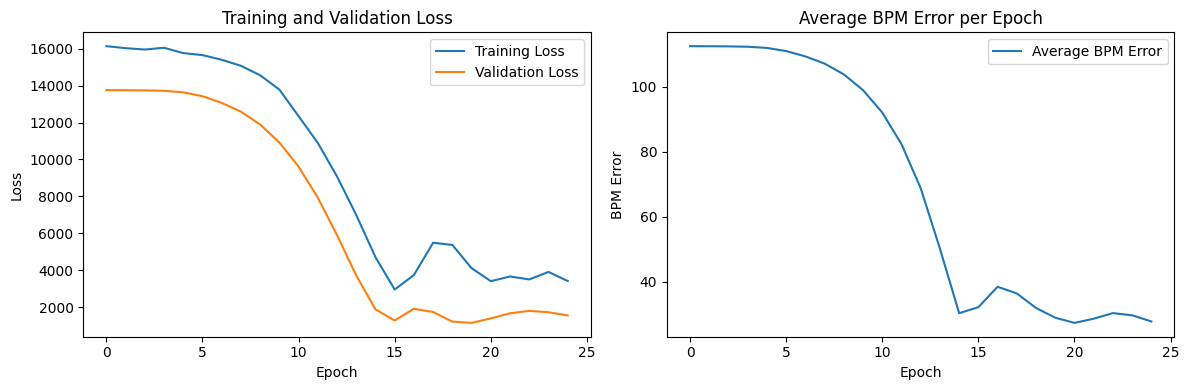


Final Metrics:
Training Loss: 3416.7030
Validation Loss: 1552.5548
BPM Error: 27.88

Best Performance:
Best Validation Loss: 1147.3737 (Epoch 20)
Best BPM Error: 27.44

Training Stability:
Loss Volatility: 755.5367

Overfitting Analysis:
Overfitting Index: 1952.4731


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. First, let's plot the basic training curves
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history[1], label='Training Loss')
plt.plot(history[2], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# BPM Error plot
plt.subplot(1, 2, 2)
plt.plot(history[3], label='Average BPM Error')
plt.xlabel('Epoch')
plt.ylabel('BPM Error')
plt.title('Average BPM Error per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


final_train_loss = history[1][-1]
final_val_loss = history[2][-1]
final_bpm_error = history[3][-1]

best_val_loss = min(history[2])
best_val_epoch = np.argmin(history[2]) + 1
best_bpm_error = min(history[3])

print("\nFinal Metrics:")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"BPM Error: {final_bpm_error:.2f}")

print("\nBest Performance:")
print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_val_epoch})")
print(f"Best BPM Error: {best_bpm_error:.2f}")


loss_changes = np.diff(history[2])
loss_volatility = np.std(loss_changes)

print("\nTraining Stability:")
print(f"Loss Volatility: {loss_volatility:.4f}")

# 4. Check for overfitting
train_val_diff = np.array(history[1]) - np.array(history[2])
overfitting_index = np.mean(train_val_diff[-5:])  # Average difference in final 5 epochs

print("\nOverfitting Analysis:")
print(f"Overfitting Index: {overfitting_index:.4f}")


50 epochs:
![Initial training results](training_results_20241124_180211.png)

25 epochs:
![second run training results](training_results_20241124_195052.png)

### Training and Validation Loss

- The fact that validation loss is lower than the training loss is not a good sign.  
    - I don't have enough data to train the model to be able to tell the difference between a good song and a bad one.

### Average BPM Error
- Starts off with a very high error, but this could be due to lack of feature engineering:
    - e.g. When detecting beats, the model may report 142 BPM when the actual tempo is 70 BPM.
    - I need to figure a solution, as Dubstep is "technically" 140, but it "feels" like 70 because it's in halftime (snare on the 3 instead of the 2)
- Quickly gets its act together in the first 15 epochs.
- Settles down at ~25 BPM error. Like, if a song’s 140 BPM, it might think it's 115-165. Close, but not DJ-ready.

### Overall

- Error drops from "yikes" to "we're getting somewhere", but it's still not where I want it to be.
- Loss curves indicate the model is learning nicely, so hopefully with a larger dataset, it will continue to improve
- 25 BPM error is far from useable in any setting, but it's a start.


I think it would be useful to compare the raw librosa tempo prediction with the ML model's tempo prediction.


Below, i started working on a simpler version of the teller net. Its results are inconclusive so far.

In [56]:
class SimplerTellerNet(nn.Module):
    def __init__(self):
        super(SimplerTellerNet, self).__init__()
        
        self.freq_convs = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d((2,8)),
            
            nn.Conv2d(8, 16, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,8))
        )
        
        # Now we know the exact size: 16 * 8 * 20 = 2560
        self.fc1 = nn.Linear(2560, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1)           # [B, 1, 32, 1292]
        x = self.freq_convs(x)       # [B, 16, 8, 20]
        x = x.view(batch_size, -1)   # [B, 2560]
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


Epoch 1/250
Training Loss: 0.1664
Validation Loss: 0.1632
BPM Error - Avg: 26.2, Max: 43.9, Min: 1.5
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 2/250
Training Loss: 0.1494
Validation Loss: 0.1646
BPM Error - Avg: 26.1, Max: 46.2, Min: 0.3
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 3/250
Training Loss: 0.1347
Validation Loss: 0.1598
BPM Error - Avg: 25.3, Max: 46.7, Min: 0.6
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 4/250
Training Loss: 0.1236
Validation Loss: 0.1508
BPM Error - Avg: 24.0, Max: 46.4, Min: 0.6
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 5/250
Training Loss: 0.1151
Validation Loss: 0.1523
BPM Error - Avg: 23.5, Max: 48.9, Min: 0.5
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 6/250
Training Loss: 0.1055
Validation Loss: 0.1479
BPM Error - Avg: 22.9, Max: 48.8, Min: 0.9
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 7/250
Training Loss: 0.1021
Validation Loss: 0.1276
BPM Error - Avg: 21.5, Max: 4

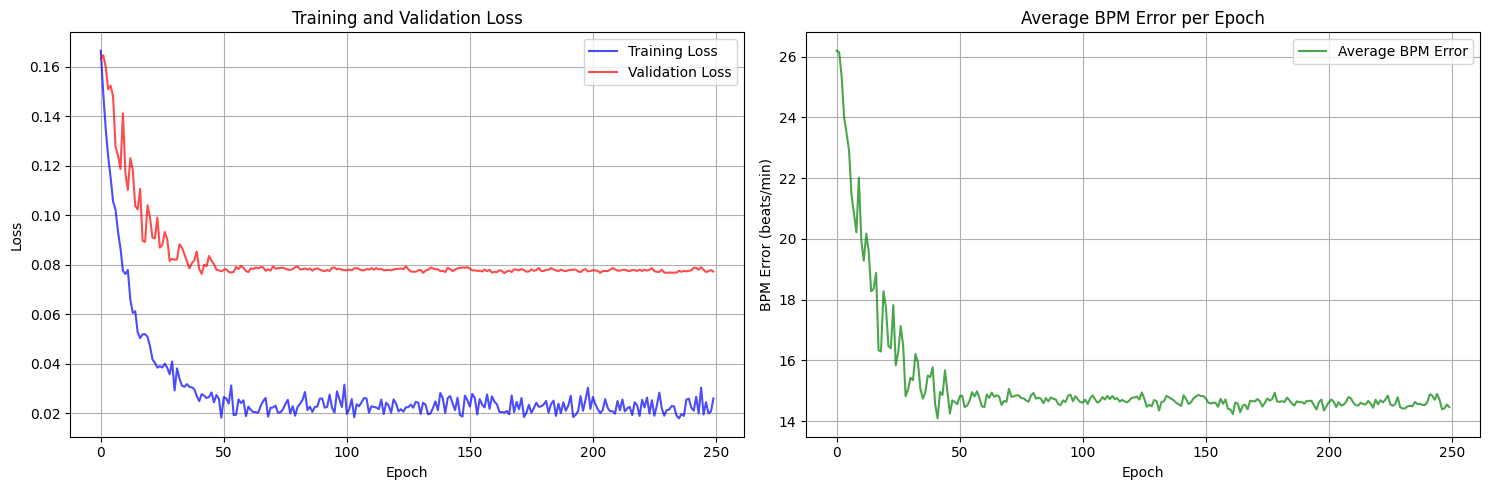

Training complete! Best validation loss: 0.0762
Final average BPM error: 15.3
Average training loss: 0.0292
Average validation loss: 0.0824


In [65]:
simple_model = SimplerTellerNet()
from datetime import datetime
import torch.optim as optim
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import MSELoss


def train_simpler_model(model, train_loader, val_loader, num_epochs=200, early_stop_patience=15):
    # Setup directories
    save_dir = os.path.join('models', 'saved')
    log_dir = os.path.join('logs')
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        model = model.to(device)
    except AttributeError as e:
        print(f"Model {model} does not have a 'to' method. Skipping to next model.")

    
    # Loss and optimizer
    criterion = nn.MSELoss()
    criterion_l1 = nn.L1Loss() 
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0001,
        weight_decay=0.01,
        amsgrad=True
    )

# Modify scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    
    optimizer,
    mode='min',
    patience=5,       
    factor=0.5,       
    min_lr=1e-6,
    )
    
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = 0.1
    
    # Metrics storage
    train_losses = []
    val_losses = []
    epoch_errors = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    # Create timestamp and files
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_file = os.path.join(log_dir, f'simple_training_log_{timestamp}.txt')
    metrics_file = os.path.join(log_dir, f'simple_training_metrics_{timestamp}.csv')
    
    # Initialize CSV
    with open(metrics_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'Epoch', 'Training Loss', 'Validation Loss', 
            'Average BPM Error', 'Max BPM Error', 'Min BPM Error',
            'Learning Rate', 'Gradient Norm'
        ])
    
    # Log training setup
    with open(log_file, 'w') as f:
        f.write(f"Training Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Device: {device}\n")
        f.write(f"Model Parameters: {sum(p.numel() for p in model.parameters())}\n")
        f.write(f"Training Samples: {len(train_loader.dataset)}\n")
        f.write(f"Validation Samples: {len(val_loader.dataset)}\n")
        f.write(f"Batch Size: {train_loader.batch_size}\n")
        f.write("Training Progress:\n" + "-" * 80 + "\n")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_bpm_errors = []
        total_norm = 0.0
        
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.squeeze(1).to(device)
            
            outputs = model(features)
            mse_loss = criterion(outputs, targets)
            l1_loss = criterion_l1(outputs, targets)
            loss = mse_loss + 0.1 * l1_loss
            
            # Backward pass with gradient clipping
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Get gradient norm for monitoring
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
            total_norm = total_norm ** 0.5
            
            optimizer.step()
            
            train_loss += loss.item()
            pred_bpm = outputs.detach().cpu().numpy() * 77 + 78
            true_bpm = targets.cpu().numpy() * 77 + 78
            bpm_errors = np.abs(pred_bpm - true_bpm)
            train_bpm_errors.extend(bpm_errors)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_bpm_errors = []
        
        with torch.no_grad():
            for features, targets in val_loader:
                features = features.to(device)
                targets = targets.squeeze(1).to(device)
                outputs = model(features)
                mse_loss = criterion(outputs, targets)
                l1_loss = criterion_l1(outputs, targets)
                loss = mse_loss + 0.1 * l1_loss
                val_loss += loss.item()  # Make sure this accumulation happens
                
                # Denormalize BPM values
                pred_bpm = outputs.cpu().numpy() * 77 + 78
                true_bpm = targets.cpu().numpy() * 77 + 78
                bpm_errors = np.abs(pred_bpm - true_bpm)
                val_bpm_errors.extend(bpm_errors)
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_bpm_error = np.mean(val_bpm_errors)
        max_bpm_error = np.max(val_bpm_errors)
        min_bpm_error = np.min(val_bpm_errors)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        epoch_errors.append(avg_bpm_error)
        
        # Write metrics
        with open(metrics_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch+1, avg_train_loss, avg_val_loss, 
                avg_bpm_error, max_bpm_error, min_bpm_error,
                current_lr, total_norm
            ])
        
        # Log epoch results
        log_msg = (f"\nEpoch {epoch+1}/{num_epochs}\n"
                  f"Training Loss: {avg_train_loss:.4f}\n"
                  f"Validation Loss: {avg_val_loss:.4f}\n"
                  f"BPM Error - Avg: {avg_bpm_error:.1f}, Max: {max_bpm_error:.1f}, Min: {min_bpm_error:.1f}\n"
                  f"Learning Rate: {current_lr:.2e}, Gradient Norm: {total_norm:.2e}\n")
        
        with open(log_file, 'a') as f:
            f.write(log_msg)
        print(log_msg)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Model saving and early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            model_path = os.path.join(save_dir, f'simple_net_{timestamp}_best.pth')
            
            torch.save({
                'Epoch': int(epoch + 1),
                'Training_Loss': float(avg_train_loss),
                'Validation_Loss': float(avg_val_loss),
                'Avg_BPM_Error': float(avg_bpm_error),
                'Max_BPM_Error': float(max_bpm_error),
                'Learning_Rate': float(current_lr)
            }, model_path)
            
            with open(log_file, 'a') as f:
                f.write(f"New best model saved! Validation Loss: {avg_val_loss:.4f}\n")
        else:
            epochs_without_improvement += 1
        
        # Early stopping check
        if epochs_without_improvement >= early_stop_patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break
    
    return model, train_losses, val_losses, epoch_errors
def visualize_training(train_losses, val_losses, epoch_errors, timestamp):
    plt.figure(figsize=(15, 5))
    
    # Create subplot layout
    plt.subplot(1, 2, 1)
    
    # Loss plot
    plt.plot(train_losses, label='Training Loss', alpha=0.7, color='blue')
    plt.plot(val_losses, label='Validation Loss', alpha=0.7, color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # BPM Error plot
    plt.subplot(1, 2, 2)
    plt.plot(epoch_errors, label='Average BPM Error', color='green', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('BPM Error (beats/min)')
    plt.title('Average BPM Error per Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    # Save and display
    plt.savefig(f'simple_training_results_{timestamp}.png', dpi=300, bbox_inches='tight', format='png')
    plt.show()
    plt.close()

model, train_losses, val_losses, epoch_errors = train_simpler_model(simple_model, train_loader, val_loader, num_epochs=250, early_stop_patience=1000)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
visualize_training(train_losses, val_losses, epoch_errors, timestamp)
print(f"Training complete! Best validation loss: {np.min(val_losses):.4f}")
print(f"Final average BPM error: {np.mean(epoch_errors):.1f}")
print(f"Average training loss: {np.mean(train_losses):.4f}")
print(f"Average validation loss: {np.mean(val_losses):.4f}")


K fold might yield even better results.


Training Fold 1/5

Epoch 1/100
Training Loss: 0.1502
Validation Loss: 0.1511
BPM Error - Avg: 25.0, Max: 37.4, Min: 1.0
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 2/100
Training Loss: 0.1427
Validation Loss: 0.1504
BPM Error - Avg: 24.9, Max: 38.5, Min: 0.7
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 3/100
Training Loss: 0.1315
Validation Loss: 0.1594
BPM Error - Avg: 25.2, Max: 43.6, Min: 1.0
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 4/100
Training Loss: 0.1237
Validation Loss: 0.1577
BPM Error - Avg: 24.7, Max: 47.5, Min: 0.8
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 5/100
Training Loss: 0.1156
Validation Loss: 0.1588
BPM Error - Avg: 24.5, Max: 48.7, Min: 0.2
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 6/100
Training Loss: 0.1136
Validation Loss: 0.1474
BPM Error - Avg: 23.6, Max: 48.8, Min: 1.8
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 7/100
Training Loss: 0.0983
Validation Loss: 0.1372
BPM Error 

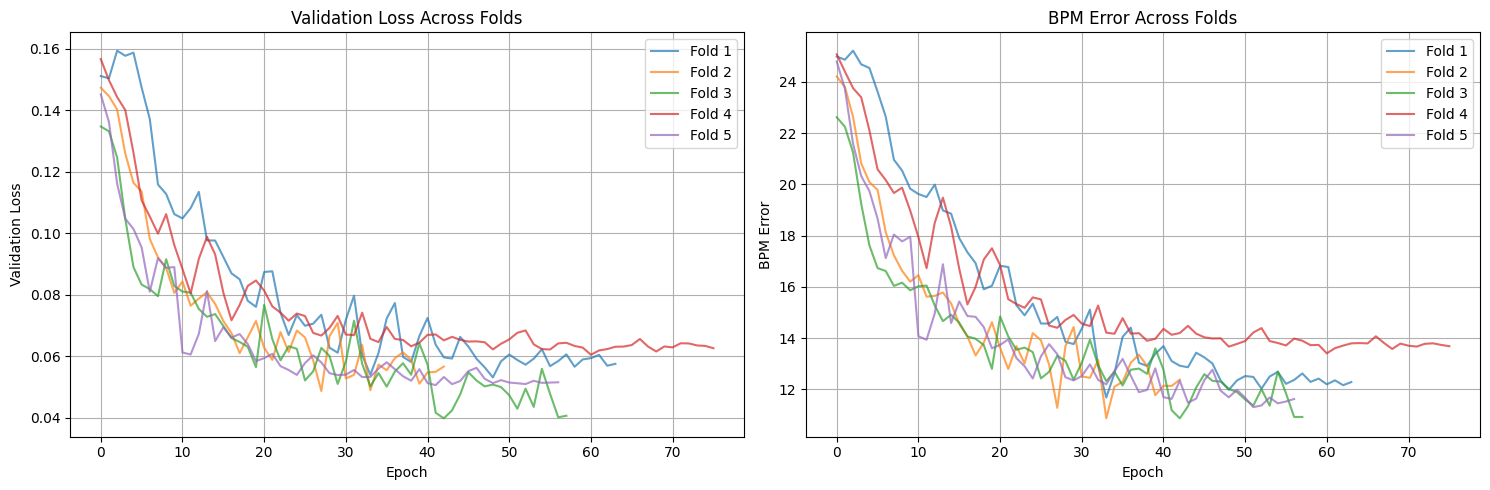

In [ ]:
from sklearn.model_selection import KFold
import copy
import numpy as np

def k_fold_train(dataset, k=5, num_epochs=100, batch_size=16, early_stop_patience=15):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []
    
    # Convert dataset to numpy arrays for splitting
    all_features = np.array([dataset[i][0].numpy() for i in range(len(dataset))])
    all_targets = np.array([dataset[i][1].numpy() for i in range(len(dataset))])
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(all_features)):
        print(f"\nTraining Fold {fold + 1}/{k}")
        
        # Create data loaders for this fold
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        
        train_loader = DataLoader(
            train_subset, 
            batch_size=batch_size, 
            shuffle=True
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=batch_size, 
            shuffle=False
        )
        
        # Initialize a new model for each fold
        model = SimplerTellerNet()
        
        # Train the model
        model, train_losses, val_losses, epoch_errors = train_simpler_model(
            model,
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            early_stop_patience=early_stop_patience
        )
        
        # Store results
        fold_results.append({
            'model': copy.deepcopy(model),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'epoch_errors': epoch_errors,
            'final_bpm_error': epoch_errors[-1],
            'best_val_loss': min(val_losses)
        })
        
        # Print fold results
        print(f"\nFold {fold + 1} Results:")
        print(f"Best Validation Loss: {min(val_losses):.4f}")
        print(f"Final BPM Error: {epoch_errors[-1]:.1f}")
    
    # Analyze results across folds
    bpm_errors = [r['final_bpm_error'] for r in fold_results]
    val_losses = [r['best_val_loss'] for r in fold_results]
    
    print("\nOverall K-Fold Results:")
    print(f"Average BPM Error: {np.mean(bpm_errors):.1f} ± {np.std(bpm_errors):.1f}")
    print(f"Average Best Val Loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
    
    # Visualize results across folds
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for i, result in enumerate(fold_results):
        plt.plot(result['val_losses'], label=f'Fold {i+1}', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Across Folds')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for i, result in enumerate(fold_results):
        plt.plot(result['epoch_errors'], label=f'Fold {i+1}', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('BPM Error')
    plt.title('BPM Error Across Folds')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fold_results

fold_results = k_fold_train(dataset, k=5, num_epochs=100, batch_size=16)

In [ ]:
print("\nPrediction Statistics:")
print(f"Prediction Mean: {np.mean(actual_predictions[:,0]):.2f}")
print(f"Prediction Std: {np.std(actual_predictions[:,0]):.2f}")
print(f"Prediction Min: {np.min(actual_predictions[:,0]):.2f}")
print(f"Prediction Max: {np.max(actual_predictions[:,0]):.2f}")


Prediction Statistics:
Prediction Mean: 85.96
Prediction Std: 0.00
Prediction Min: 85.96
Prediction Max: 85.96


![results](comparison_result_text.png)


Summary:
- Librosa is a good starting point, but suffers from systematic issues (e.g. outliers from tempo vagueness)
- The trained model demonstrates the ability to generalize better, significantly reducing average error and handling edge cases (like halftime/double-time) more effectively than Librosa.